# COMPAS """bedre tittel"""
## Prosjekt 1 i HON2200 - april 2021
### Adrian Ommundsen, Gulla Torvund, Silje Bentdal og Theodor O. Aaberge

"""abstract"""

"""innledning"""

skjelett:

* abstract

* innledning

* 1a + 1b + 1d

* 1c

* diskusjon

* konklusjon



# Leser inn og undersøker dataene

For å forstå dataene, ønsker vi å undersøke spesifikke aspekter ved dem. Vi vil se på relativ frekvens av faktorer innad i de ulike gruppene og sammenligne resultatene. Tilfellene vi skal se på er 
* hvor ofte ulike grupperinger av mennesker(kvinner, menn, hvite og svarte) gjentar forbrytelser og blir predikert å begå straffbare handlinger i framtiden (som andel, ikke totalt antall).

* hvor ofte ulike grupper fikk ulike risikoskårer.

* hvor ofte de som begikk nye straffbare hadlinger (og de som ikke gjorde det) fikk ulike risikoskårer, og hvordan dette ser ut hvis du kun ser på hvite eller svarte.

Først importerer vi nødvendige pakker for hele rapporten. `pandas`brukes i stor grad ettersom vi behandler dataene som "DataFrames".

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import plot_partial_dependence

Vi leser inn dataen. Vi kvitter oss med den dataen hvor siktelsesdatoen er mer enn 30 dager unna datoen for arrestasjonen - ProPublica anså denne dataen som for usikker til å inkludere i studien.

In [2]:
data = pd.read_csv("..//Data/compas-scores-two-years.csv")
data = data[data["days_b_screening_arrest"] <= 30]
data = data[data["days_b_screening_arrest"] >= -30]

Vi lager en ny `pandas.DataFrame` og inkluderer den dataen som vi ønsker å se nærmere på. Som ProPublica, definerer vi at de som har fått COMPAS-score "Medium" eller "High" predikeres til å residivere innen to år.

In [3]:
df = pd.DataFrame({
    "kvinne": data.sex == "Female",
    "hvit": data.race == "Caucasian",
    "svart": data.race == "African-American",
    "tilbakefall": data.two_year_recid == 1,
    "predikert_tilbakefall": data.score_text != "Low",
    "lav_score": data.score_text == "Low",
    "medium_score": data.score_text == "Medium",
    "høy_score": data.score_text == "High",})

For å regne ut den relative frekvensen av forekomst av en spesifikk egenskap innad i en gruppe, brukes `prosentandel`. Funksjonen `barplott` tar inn de egenskapene og gruppene vi ønsker å undersøke og plotter resultatene i tabell og barplott.

In [4]:
def prosentandel(fokus, gruppe):
    """Regner ut prosentandelen av gruppen (gruppe) som har den spesifikke egenskapen (fokus)
    """
    return float(f'{len(df[fokus & gruppe]) / len(df[gruppe]) * 100:.1f}')

def barplott(fokusliste, gruppeliste, kol_navn, rad_navn, tittel, ha_tabell = 'Ja'):
    """Lager en DataFrame med ønskede prosentandeler og plotter den i et barplott.
    Tar inn lister over egenskaper og grupper man ønsker å undersøke, samt navn som blir synlig i tabell og plott
    """
    tabell = pd.DataFrame(columns=kol_navn)
    
    for i,fokus in enumerate(fokusliste):
        tabell.loc[i] = [prosentandel(fokus, gruppe) for gruppe in gruppeliste]
    tabell.index = rad_navn
    ax = tabell.plot.bar(colormap='Set3', figsize=(8,6), rot=0)
    ax.set_ylabel('Prosentandel')
    ax.set_title(tittel)
    plt.rcParams.update({'font.size': 13})
    if ha_tabell == 'Ja': # default er å vise tabellen i tillegg til barplottet
        display(tabell)         

Nå er vi rustet får å se på de ulike aspektene:


### Hvor ofte gjentar ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) forbrytelser og blir predikert å begå straffbare handlinger i framtiden?

,Kvinner,Menn,Hvite,Svarte
Tilbakefallende,35.1,47.9,39.1,52.3
Predikert tilbakefallende,40.5,45.5,33.1,57.6


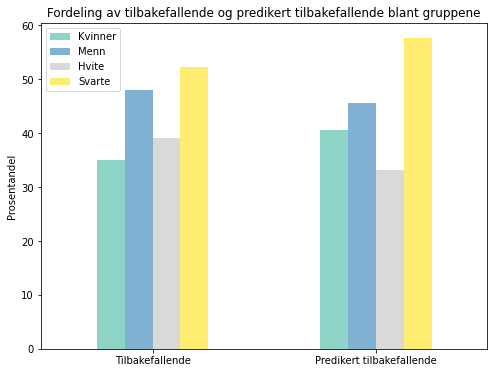

In [5]:
resid_predresid = [df.tilbakefall, df.predikert_tilbakefall]
gruppe = [df.kvinne, ~df.kvinne, df.hvit, df.svart]
gruppenavn = ['Kvinner', 'Menn', 'Hvite', 'Svarte']
resid_predresid_navn = ['Tilbakefallende', 'Predikert tilbakefallende']
tittel1 = 'Fordeling av tilbakefallende og predikert tilbakefallende blant gruppene'
barplott(resid_predresid, gruppe, gruppenavn, resid_predresid_navn, tittel1)

Vi ser at COMPAS-algoritmen predikerer en større andel svarte og kvinner til å residivere enn dét som faktisk er tilfelle, mens den vipper i motsatt retning for menn og hvite.


### Hvor ofte fikk de ulike gruppene de tre risikoskårene?


,Kvinner,Menn,Hvite,Svarte
Lav score,59.5,54.5,66.9,42.4
Medium score,27.7,25.7,22.5,31.0
Høy score,12.9,19.9,10.6,26.6


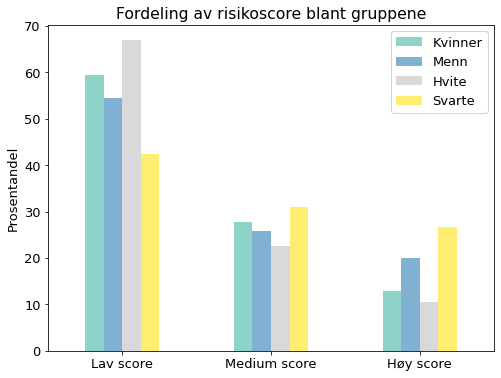

In [6]:
score = [df.lav_score, df.medium_score, df.høy_score]
score_navn = ['Lav score', 'Medium score', 'Høy score']
tittel2 = 'Fordeling av risikoscore blant gruppene'

barplott(score, gruppe, gruppenavn, score_navn, tittel2)

Det mest fremtredende resultatet her, er at hvite har tydelig lavere score enn svarte. Hvite har en overveiende prosentandel som har lav score, mens de svartes score er mer jevt fordelt.


### Hvor ofte fikk tilbakefallende og ikke-tilbakefallende ulike risikoskårer, og hvordan ser ut når vi kun ser på hvite og svarte?

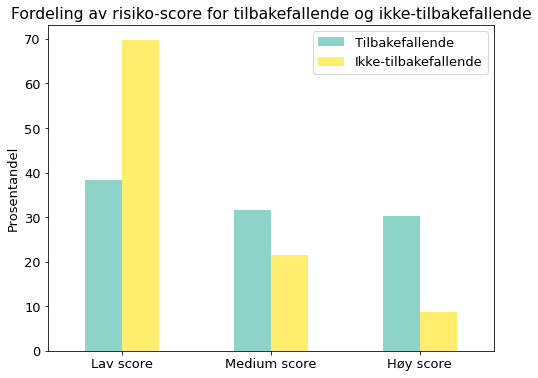

In [7]:
resid = [df.tilbakefall, ~df.tilbakefall]
resid_navn = ['Tilbakefallende', 'Ikke-tilbakefallende']
tittel3 = 'Fordeling av risiko-score for tilbakefallende og ikke-tilbakefallende'

barplott(score, resid, resid_navn, score_navn, tittel3, ha_tabell = 'Nei')

Totalt sett er COMPAS-algoritmen tydelig bedre på å predikere de som ikke tilbakefaller enn de som tilbakefaller.

,Tilbakefallende hvite,Tilbakefallende svarte,Ikke-tilbakefallende hvite,Ikke-tilbakefallende svarte
Lav score,49.6,28.5,78.0,57.7
Medium score,30.7,33.4,17.3,28.4
Høy score,19.7,38.2,4.8,13.9


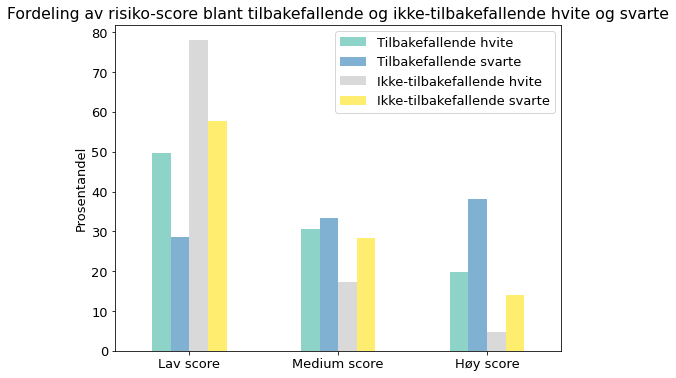

In [8]:
etnisk_resid = [df.hvit & df.tilbakefall, df.svart & df.tilbakefall, df.hvit & ~df.tilbakefall, df.svart & ~df.tilbakefall]
score_navn = ['Lav score', 'Medium score', 'Høy score']
etnisk_resid_navn = ["Tilbakefallende hvite", "Tilbakefallende svarte","Ikke-tilbakefallende hvite","Ikke-tilbakefallende svarte"]
tittel4 = 'Fordeling av risiko-score blant tilbakefallende og ikke-tilbakefallende hvite og svarte'

barplott(score, etnisk_resid, etnisk_resid_navn, score_navn, tittel4)

COMPAS-scoren gjenspeiler ikke-tilbakefallende hvite godt og ikke-tilbakefallende svarte nogenlunde. For tilbakefallende svarte er den såvidt bedre enn en random-algoritme, og for tilbakefallende hvite predikerer den dårligere enn en random-algoritme.

## Rater og betinget sannsynlighet for undergrupper

Vi ønsker nå å se på data for følgende grupper:
* Hele befolkningen
* Kvinner 
* Menn 
* Hvite
* Svarte

Vi undersøker raten av falske positive, sanne positive, falske negative og sanne negative. I tillegg ønsker vi å se på sannsynligheten for at gruppen residiverer (tilbakefall) gitt at de er blitt predikert til å gjøre det.   
Til dette bruker vi funksjonene `falsk_positiv`, `sann_positiv`, `falsk_negativ`, `sann_negativ` og `p_residiv_g_høy`. 

In [9]:
def falsk_positiv(gruppe):
    """Regner ut raten av falske positive for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av falske positive i prosent med én desimal. 
    """
    # FP / (FP + SN)
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & ~df.tilbakefall]) / len(df[gruppe & ~df.tilbakefall]) * 100:.1f}')

def sann_positiv(gruppe):
    """Regner ut raten av sanne positive for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av sanne positive i prosent med én desimal.
    """
    # SP / (SP + FN)
    # sensitivitet
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.tilbakefall]) * 100:.1f}')

def falsk_negativ(gruppe):
    """Regner ut raten av falske negative for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av falske negative i prosent med én desimal.
    """
    # FN / (FN + SP)
    return float(f'{len(df[gruppe & ~df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.tilbakefall]) * 100:.1f}')

def sann_negativ(gruppe):
    """Regner ut raten av sanne negative for en gitt gruppe
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: raten av sanne negative i prosent med én desimal.
    """
    # SN / (SN + FP)
    # spesifisitet
    return float(f'{len(df[gruppe & ~df.predikert_tilbakefall & ~df.tilbakefall]) / len(df[gruppe & ~df.tilbakefall]) * 100:.1f}')

def p_residiv_g_høy(gruppe):
    """Regner ut sannsynligheten for at en gruppe residiverer gitt at de har blitt predikert til å gjøre det
    -----
    Arguments:
        gruppe: array med True/False verdier for dataframe
    
    Return:
        float: sannsynlighet i prosent med én desimal.
    """
    return float(f'{len(df[gruppe & df.predikert_tilbakefall & df.tilbakefall]) / len(df[gruppe & df.predikert_tilbakefall]) * 100:.1f}')

In [13]:
alle = np.full(len(df), True)

In [11]:
functions = [falsk_positiv, falsk_negativ, sann_positiv, sann_negativ, p_residiv_g_høy]
grouplist = [alle, df.kvinne, ~df.kvinne, df.hvit, df.svart]
namelist = ['Alle', 'Kvinner', 'Menn', 'Hvite', 'Svarte']
d = {}
for name, group in zip(namelist, grouplist):
    inner_dict = {}
    for function in functions:
        inner_dict[function.__name__] = function(group)
    d[name] = inner_dict
d

{'Alle': {'falsk_positiv': 30.3,
  'falsk_negativ': 38.3,
  'sann_positiv': 61.7,
  'sann_negativ': 69.7,
  'p_residiv_g_høy': 63.0},
 'Kvinner': {'falsk_positiv': 30.2,
  'falsk_negativ': 40.4,
  'sann_positiv': 59.6,
  'sann_negativ': 69.8,
  'p_residiv_g_høy': 51.7},
 'Menn': {'falsk_positiv': 30.3,
  'falsk_negativ': 37.9,
  'sann_positiv': 62.1,
  'sann_negativ': 69.7,
  'p_residiv_g_høy': 65.4},
 'Hvite': {'falsk_positiv': 22.0,
  'falsk_negativ': 49.6,
  'sann_positiv': 50.4,
  'sann_negativ': 78.0,
  'p_residiv_g_høy': 59.5},
 'Svarte': {'falsk_positiv': 42.3,
  'falsk_negativ': 28.5,
  'sann_positiv': 71.5,
  'sann_negativ': 57.7,
  'p_residiv_g_høy': 65.0}}

Spesifisiteten (sanne negative) sier oss noe om hvor bra COMPAS klarer å identifisere personer som ikke kommer til å få tilbakefall. Sensitiviteten (sanne positive) sier noe om hvor bra COMPAS klarer å identifisere personer som kommer til å residivere. Det er først når begge disse tallene er høye det kan konkluderes med at algoritmen er god. Dersom det ene tallet er relativt høyt, imens den andre er relativt lavt sier oss bare om algoritmen er strengere i den ene eller andre retningen. For eksempel har vi for hvite at COMPAS har høy sann negativ rate og lav sann positiv rate. Ut ifra dette kan vi trekke frem en hypotese om at den generelt gir lav score for hvite.

Falske positive er personer som ikke residiverer, men som COMPAS predikerer vil gjøre det. Dette vil være mennesker som får strengere straff enn fortjent. Raten av falske positive vil være viktig å holde lav for individualistiske samfunn.   
Falske negative er personer vi kanskje slipper ut i samfunnet igjen, men som likevel begår en kriminell handling. Disse menneskene vil utgjøre en fare for samfunnet. Raten av falske negative vil være viktig å holde lav for kollektivistiske samfunn. 

Den betingede sannsynligheten sier noe om hvor sannsynlig det er at gruppen residiverer gitt at de blir predikert til å gjøre det. Denne er relativt lav for alle grupper. 

###  Skjevheter i COMPAS på bakgrunn av rase

Vi undersøker så skjevheter i COMPAS på bakgrunn av rase ved å kontrollere for kjønn, alder, kriminell historie og eventuell gjentatt forbrytelse. Her gjør vi hovedsaklig det samme som ProPublica-studien: vi trener en algoritme på en del av dataen vi har, bruker denne modellen til å predikere den resterende testdataen og sjekker egenskapene til modellen. Vi bruker `sklearn`-biblioteket og dens `LogisticRegression`for å trene modellen vår.

In [3]:
# velger hensiktsmessig data (kopierer fra oppgavetekst)
X = data[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)
Y = data["score_text"] != "Low"
# splitter dataen i fire med den flotte train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [4]:
# trener og tester superkjapt med sklearn sine innebygde funksjoner
model = LogisticRegression(random_state=0, max_iter=10000)
model.fit(X_train, Y_train)
Y_mdl = model.predict(X_test)
print(accuracy_score(Y_mdl, Y_test))

0.7441295546558705


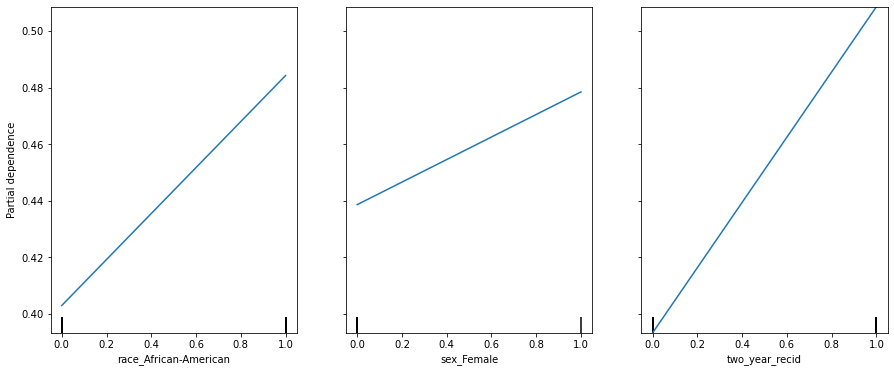

In [6]:
#plotter partial dependance
#her bør det undersøkes mye mer
features = ["race_African-American","sex_Female","two_year_recid"]
plot_partial_dependence(model, X_train, features)
plt.gcf().set_size_inches(15, 6)

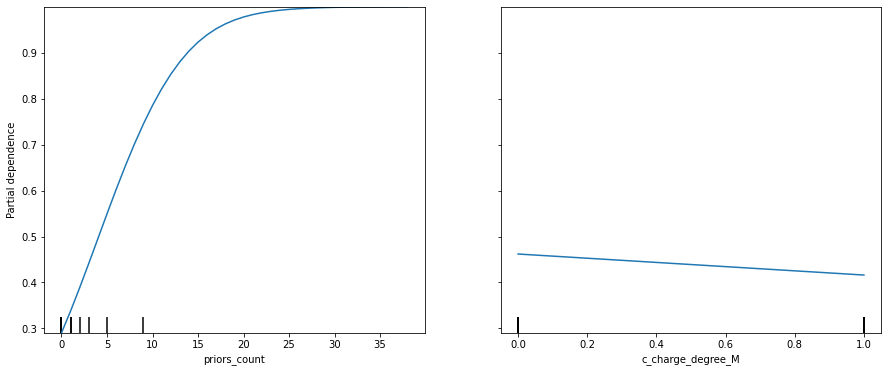

In [7]:
features = ["priors_count", "c_charge_degree_M"]
plot_partial_dependence(model, X_train, features)
plt.gcf().set_size_inches(15, 6)

## Vekten mht etnisitet??

In [8]:
def sigmoid(z):    
    return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))

In [9]:
# her står det at man bør få 1.45. 
control = sigmoid(model.intercept_)
coefs = model.coef_[0]
racialBias = np.exp( coefs[4]) / (1 - control + (control * np.exp(coefs[4])))
print(np.mean(racialBias))

1.4571093789309733
